# Exploring the review scores data

There's a lot going on in this dataset. This notebook follows my intuitions in an attempt to get a sense of the data.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

pd.set_option('precision', 2)
np.set_printoptions(precision=2)


con = sqlite3.connect('pitchfork.db')
reviews = pd.read_sql('SELECT * FROM reviews', con)
genres = pd.read_sql('SELECT * FROM genres', con)
labels = pd.read_sql('SELECT * FROM labels', con)
con.close()

## Score and Best New Music distributions


Averages:
best_new_music    0.08
score             7.08
dtype: float64

Standard Deviation:
best_new_music    0.26
score             1.06
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


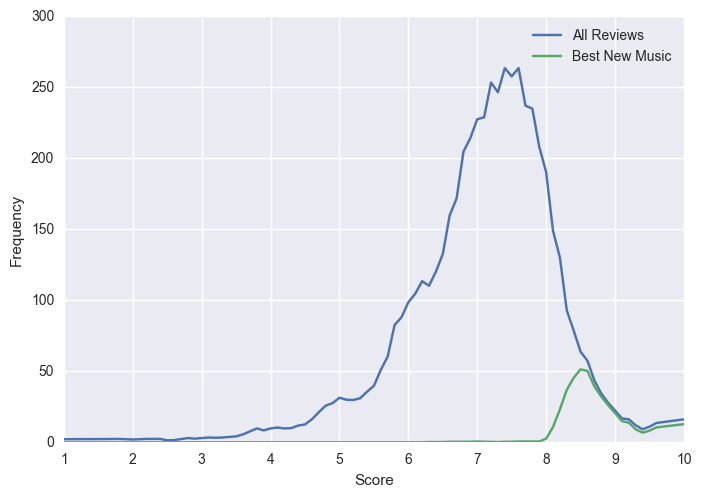

In [2]:
print('\nAverages:')
print(np.mean(reviews[['best_new_music', 'score']]))

print('\nStandard Deviation:')
print(np.std(reviews[['best_new_music', 'score']]))

g = reviews.groupby('score')
info = g['best_new_music'].agg(['sum','count']).reset_index()

plt.plot(info['score'], savgol_filter(info['count'], 5, 1), label = 'All Reviews') 
plt.plot(info['score'], savgol_filter(info['sum'], 5, 1), label = "Best New Music") 
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Scores are roughly normally distributed, a little negative skew. The average release gets a score of about 7.0. The distribution declines pretty sharply at about 8.0, no wonder Pitchfork has [a special page for 8.0+ reviews](http://pitchfork.com/best/high-scoring-albums/)...

There is also effectively no best new music before 8.0. And nearly every release above 8.5 is categorized as best new music. Makes you kind of feel bad for all the 8.3s and 8.4s that narrowly missed the cutoff...

## Score by day of week, day of month

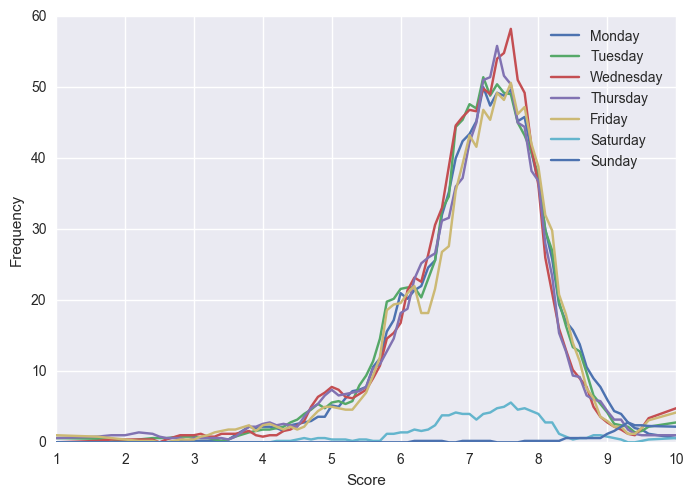

In [3]:
weekdays = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
g = reviews.groupby(['score','pub_weekday'])
info = g[['reviewid']].size().unstack().fillna(0)

for i in range(7):
    info[i]
    plt.plot(info.index, savgol_filter(info[i], 5, 1), label = weekdays[i]) 
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

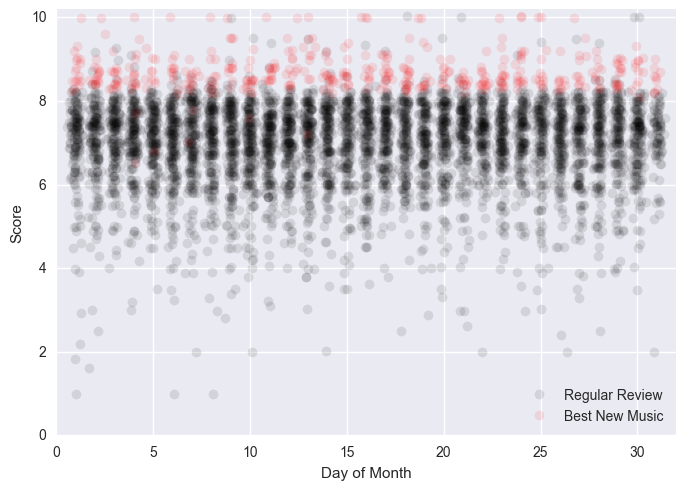

In [4]:
def add_jitter(points, sd = 0.01):
    jitter = np.random.normal(loc = 0, scale = sd, size = points.shape);
    return points + jitter

styles, legend_labs = ['ko','ro'], ['Regular Review','Best New Music']
for bnm in range(2):
    subset = reviews[reviews.best_new_music == bnm]
    x = add_jitter(subset.pub_day, sd = 0.15)
    y = add_jitter(subset.score, sd = 0.015)
    plt.plot(x,y, styles[bnm], alpha = 0.1, label = legend_labs[bnm])
    
plt.axis([0,32,0,10.2])
plt.xlabel('Day of Month')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

What are the albums in the 9.5-10 range that are *not* best new music?

In [5]:
idx = (reviews.best_new_music == 0) & (reviews.score > 9.4)
reviews.loc[idx, ['artist', 'title', 'pub_date'] ]

,artist,title,pub_date
51,ice cube,death certificate,2016-11-27
69,leonard cohen,im your man,2016-11-20
95,minutemen,double nickels on the dime,2016-11-13
147,bob dylan,blood on the tracks,2016-10-30
298,brian eno,another green world,2016-09-18
394,stevie wonder,songs in the key of life,2016-08-21
473,nina simone,in concert,2016-07-30
547,lauryn hill,the miseducation of lauryn hill,2016-07-10
5446,can,tago mago [40th anniversary edition],2011-12-09


All of these are classics that somehow missed the "best new reissue" label, i suppose.

## Ratings by Genre

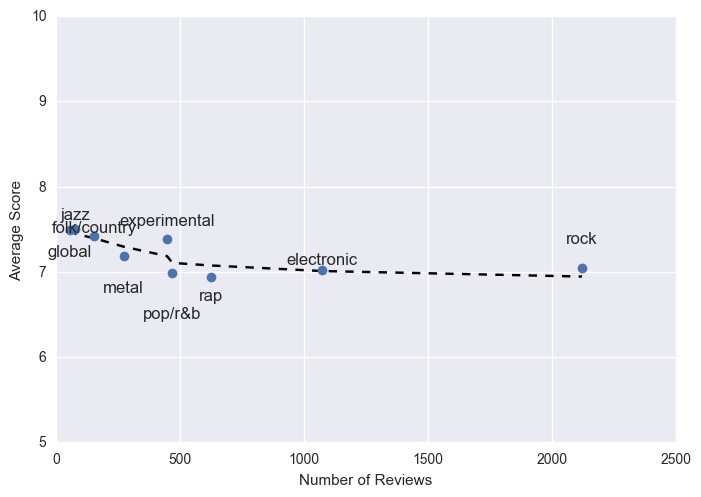

In [6]:
genre_data = pd.merge(reviews[['reviewid','score']], genres, 
                  on = 'reviewid')

g = genre_data.groupby('genre')
table = g['score'].agg(['count', 'mean', 'std']).reset_index()

# plot the average at each level of count
avgline = table.groupby('count')['mean'].mean().reset_index()
avgline['mean'] = savgol_filter(avgline['mean'], 5, 1)
plt.plot(avgline['count'], avgline['mean'],'k--')

plt.plot(table['count'],table['mean'],'o', alpha = 1)

for j, row in table.iterrows():
    curr_avg = float(avgline.loc[avgline['count'] == row['count'], 'mean'])
    jitter = np.random.uniform(0.1, high = 0.5)
    if row['mean'] < curr_avg: jitter*= -1.0
    
    plt.text(row['count'], row['mean'] + jitter, row['genre'], 
             ha = 'center', va = 'center')

plt.ylabel('Average Score')
plt.xlabel('Number of Reviews')
plt.ylim([5, 10])
plt.show()

### Are Jazz and Global more highly rated?

In [7]:
from scipy.stats import ttest_ind
for j in ['jazz', 'global']:
    curr_genre = genre_data.loc[genre_data.genre == j, 'score']
    all_others = genre_data.loc[genre_data.genre != j, 'score']
    tstat, pval = ttest_ind(curr_genre, all_others)

    print(j, 'p = ' + str(round(pval, 4)))

r = np.corrcoef(table['count'], table['mean'])
print('\nCount-Score Correlation: ' + str(r[0][1]))

jazz p = 0.0004
global p = 0.0033

Count-Score Correlation: -0.616588784251


Its unlikely that Jazz and Global reviews are sourced from the same distribution as other genres. Pitchfork reviews far fewer of these releases compared to other genres, so probably only very high quality releases are considered for review. 

More generally there is a pretty strong negative correlation between review frequency and average rating. My guess:

1. Writers are most likely to write about genres they are familiar with.
2. It is difficult to negatively review a genre if you are unfamiliar with it -- i.e., how do you know Jazz is "bad" if you don't know very much about it? Conversely, it is possible to love a release from a completely unfamiliar genre.

### Genre-Genre Overlap

In [8]:
all_genres = [ i for i in pd.unique(genres.genre) if i is not None ] 

table = pd.DataFrame(index = all_genres, columns = all_genres)
for i in all_genres:
    g1 = genres.loc[genres.genre == i, 'reviewid'] 
    
    for j in all_genres:
        g2 = genres.loc[genres.genre == j, 'reviewid']
        
        table.loc[i,j] = sum(g1.isin(g2))

table

,rock,rap,electronic,global,experimental,pop/r&b,folk/country,jazz,metal
rock,2120,8,256,7,184,28,3,7,75
rap,8,623,16,2,8,29,0,3,2
electronic,256,16,1070,9,49,53,7,13,7
global,7,2,9,55,6,9,0,2,0
experimental,184,8,49,6,447,4,1,12,10
pop/r&b,28,29,53,9,4,469,5,5,1
folk/country,3,0,7,0,1,5,153,0,5
jazz,7,3,13,2,12,5,0,77,8
metal,75,2,7,0,10,1,5,8,272


Interesting issue for later: which genres are more associated with others than you'd think, assuming genres are associated uniformly.

## Ratings by Author Type

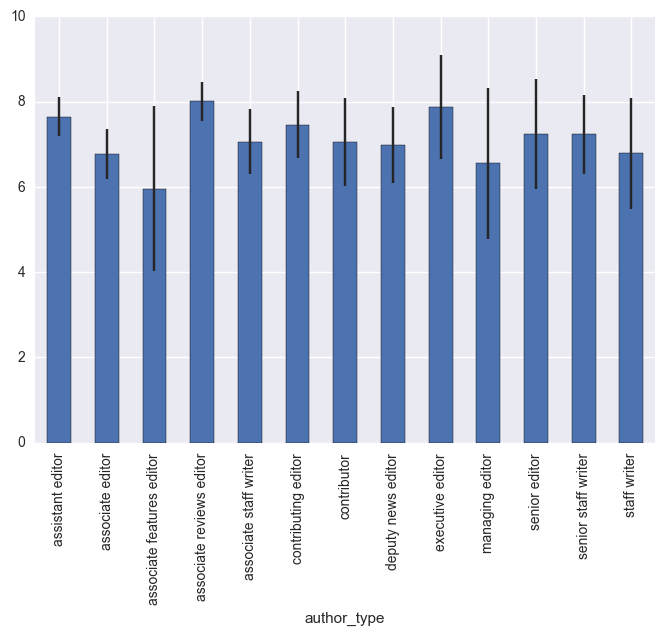

In [9]:
g = reviews.groupby('author_type')
table = g['score'].agg(['mean', 'std'])

table['mean'].plot(kind='bar', yerr = table['std']);
plt.show()

## Ratings by Record Label

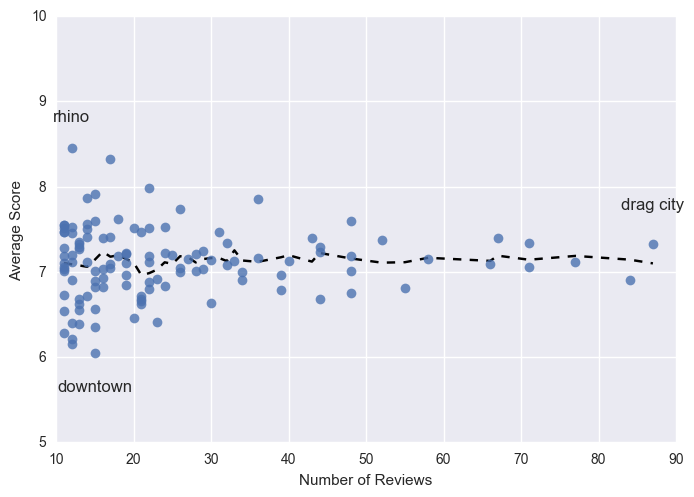

In [10]:
label_data = pd.merge(reviews[['reviewid','score']], labels, 
                  on = 'reviewid')

g = label_data.groupby('label')
table = g.score.agg(('mean','std','count'))
table['ratio'] = table['mean'] / table['count']

# remove labels with only a handful of reviews
table = table.loc[table['count'] > 10]
table = table[table.index != 'self-released']

# plot the average at each level of count
avgline = table.groupby('count')['mean'].mean().reset_index()
avgline['mean'] = savgol_filter(avgline['mean'], 5, 1)
plt.plot(avgline['count'], avgline['mean'],'k--')

# plot each label as a point
plt.plot(table['count'], table['mean'],'o', alpha = 0.8)

# identify some standouts
items = [
         table['mean'].idxmax(), 
         table['mean'].idxmin(),
         table['count'].idxmax()
        ]

for idx in items:
    
    x, y = table.loc[idx, 'count'], table.loc[idx, 'mean']
    curr_avg = float(avgline.loc[avgline['count'] == x, 'mean'])
        
    jitter = np.random.uniform(0.1, high = 0.5)
    if y < curr_avg: jitter*= -1.0
        
    plt.text(x, y + jitter, idx,
            ha = 'center', va = 'center')

plt.ylabel('Average Score')
plt.xlabel('Number of Reviews')
plt.ylim([5, 10])
plt.show()

On average, Pitchfork writers don't appear to favor labels that they review frequently. Less-frequently-reviewed labels are more variable, but that's what you'd expect from normally distributed scores. 

The top label ([Rhino](http://www.rhino.com/)) does a lot of re-releases, which tend to be more highly rated. Besides that, there do seem to be labels that are rated considerably higher/lower than others...